In [4]:
import os
os.chdir('/home/ssobti/projects/mir_tud/packages/ciberatac-main/src/mave')
import pandas as pd
import numpy as np
import scanpy as sc
import itertools
import pickle
import shelve

In [5]:
weighting_scheme = 'tmp_shap'
weights = [0.0001, 1, 1, 0.01]

In [6]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.3 numpy==1.21.6 scipy==1.10.0 pandas==1.5.2 scikit-learn==1.2.0 statsmodels==0.13.5 pynndescent==0.5.8


In [7]:
adata = sc.read('/home/ssobti/projects/mir_tud/110222_filtered_data/miR.concat.raw.adata_gex.guide_assigned.h5')

Only considering the two last: ['.guide_assigned', '.h5'].
Only considering the two last: ['.guide_assigned', '.h5'].


In [8]:
### feed in raw matrix (adata.X) into VAE with filter out cells with low # genes and genes expressed in low # of cells
adata.var_names_make_unique()

In [9]:
adata

AnnData object with n_obs × n_vars = 30035 × 36601
    obs: 'sample', 'barcode', 'guide', 'lor', 'pvalue', 'adj_pvalue', 'max_umi', 'n_umi', 'm_umi', 'v_umi', 'log_max_umi', 'log_n_umi', 'log_m_umi'
    var: 'feature_type'

normalizing counts per cell
    finished (0:00:06)


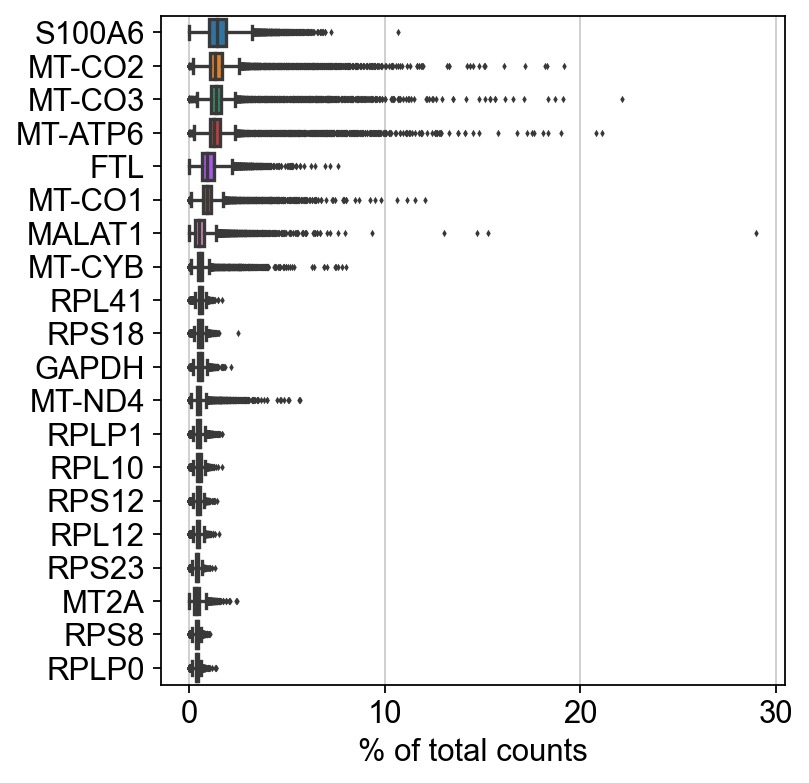

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [11]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1 cells that have less than 200 genes expressed
filtered out 6345 genes that are detected in less than 3 cells


In [12]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

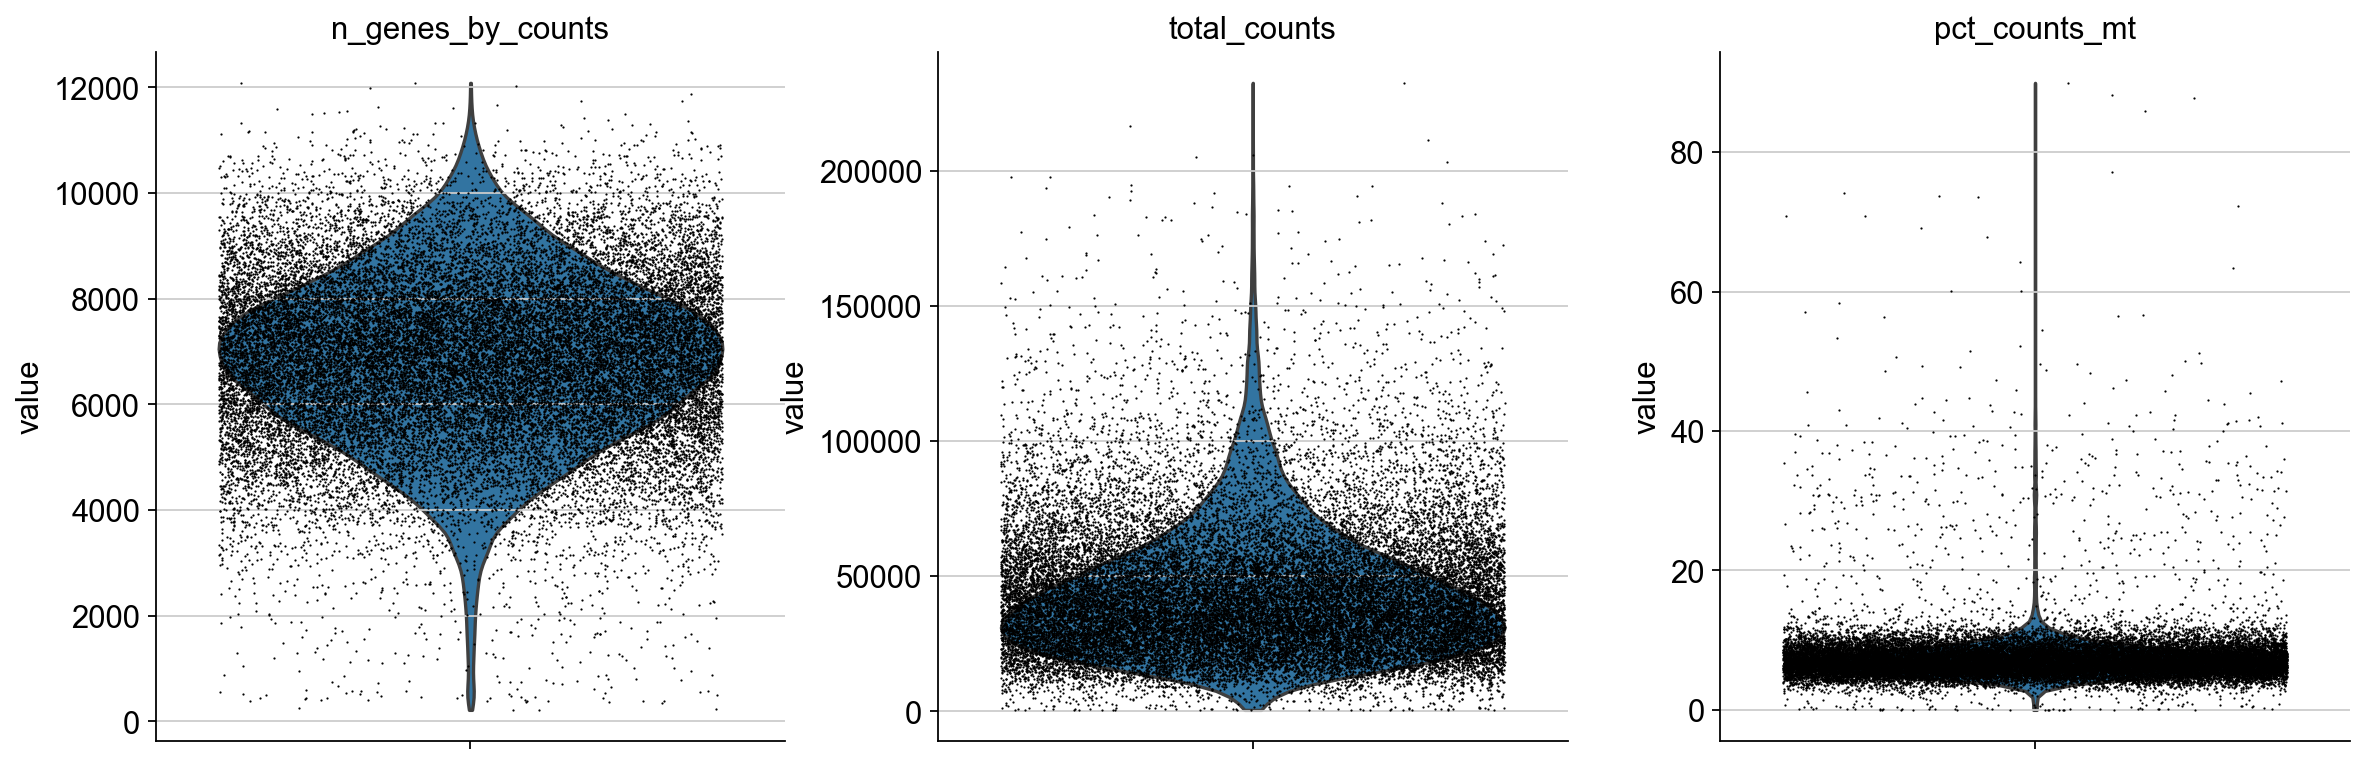

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

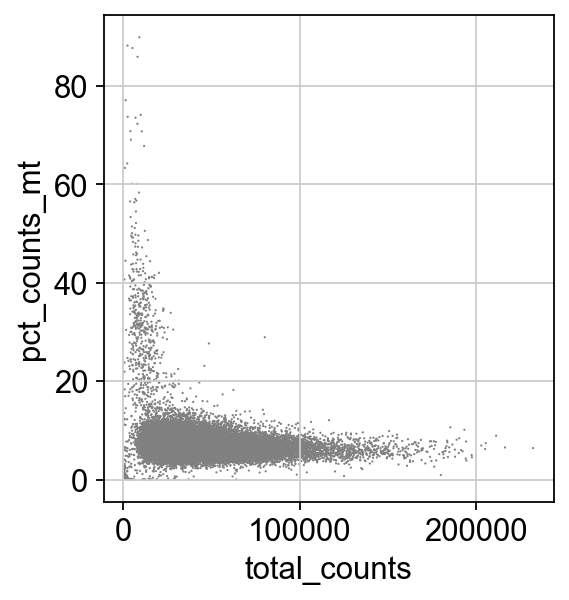

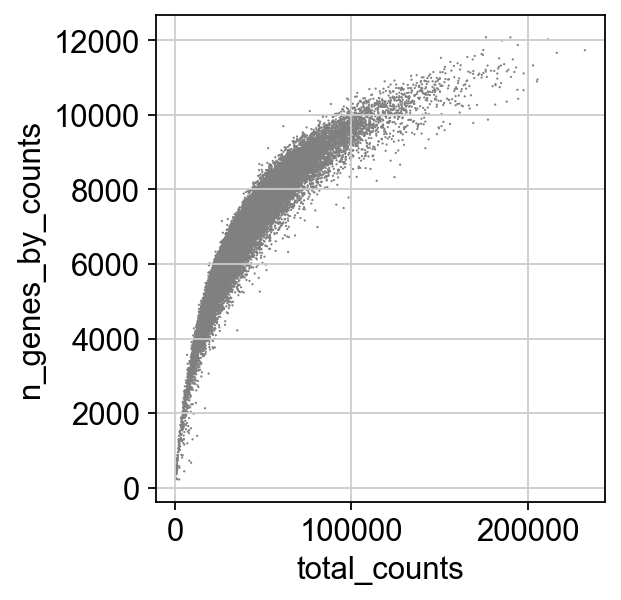

In [14]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [15]:
adata = adata[adata.obs.pct_counts_mt < 12, :]

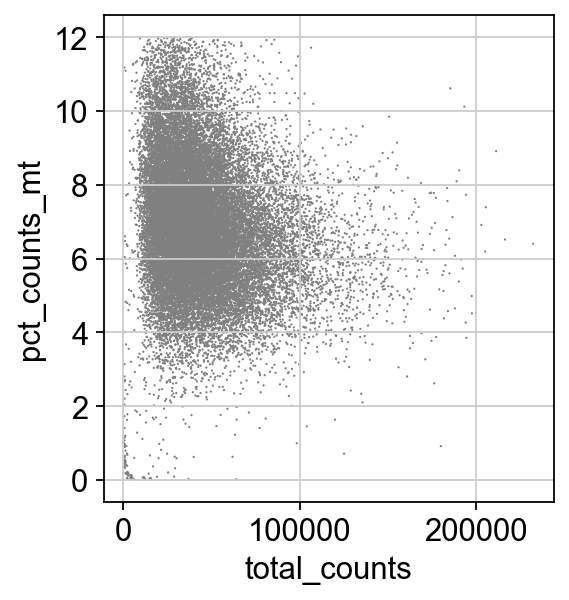

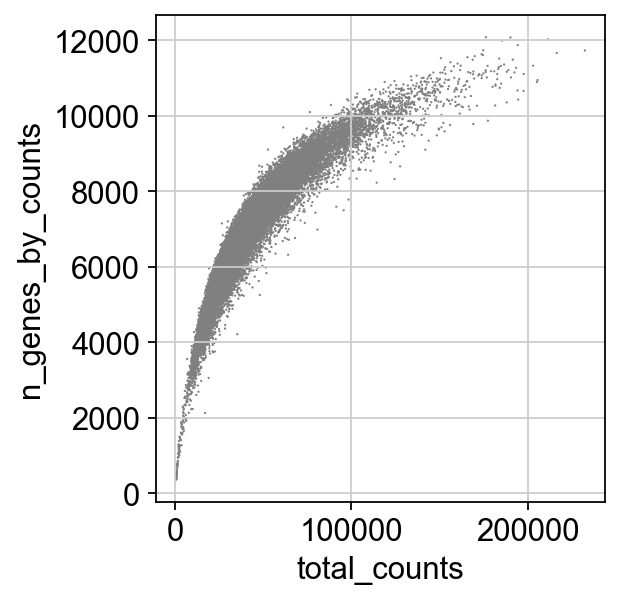

In [16]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [17]:
### remove ('hsa-miR-92a-3p', ['miR_1:TCACAAGTCGGCATAT-1']) from adata
cells_to_keep = [cell for cell in adata.obs.index.to_list() if cell != 'miR_1:TCACAAGTCGGCATAT-1']
adata = adata[cells_to_keep,:]

In [18]:
adata.obs

,sample,barcode,guide,lor,pvalue,adj_pvalue,max_umi,n_umi,m_umi,v_umi,log_max_umi,log_n_umi,log_m_umi,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
miR_1:AAACCCAAGGAGAGGC-1,miR_1,AAACCCAAGGAGAGGC,hsa-miR-203a-3p,5.453121,2.983000e-159,3.010603e-152,67.0,78.0,0.196474,11.324937,1.826075,1.892095,-0.706696,6001,6001,33957.0,2912.0,8.575551
miR_1:AAACCCAAGGTAAACT-1,miR_1,AAACCCAAGGTAAACT,hsa-miR-93-3p,6.012001,3.907611e-225,3.943769e-218,97.0,108.0,0.272040,23.713686,1.986772,2.033424,-0.565367,6871,6870,31930.0,2091.0,6.548700
miR_1:AAACCCACAACGATCT-1,miR_1,AAACCCACAACGATCT,hsa-miR-130b-3p,5.864701,3.299362e-202,3.329893e-195,89.0,113.0,0.284635,19.981910,1.949390,2.053078,-0.545712,7448,7448,42786.0,3784.0,8.844014
miR_1:AAACCCACACGATTCA-1,miR_1,AAACCCACACGATTCA,TuD_NC_18,5.859895,2.574602e-201,2.598426e-194,96.0,114.0,0.287154,23.235516,1.982271,2.056905,-0.541886,8043,8042,58540.0,5896.0,10.071746
miR_1:AAACCCACAGTCAACT-1,miR_1,AAACCCACAGTCAACT,hsa-miR-147b-5p,5.632808,3.564463e-178,3.597446e-171,71.0,86.0,0.216625,12.725683,1.851258,1.934498,-0.664292,6582,6582,31581.0,2431.0,7.697667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
miR_3:TTTGGTTTCGGACTTA-1,miR_3,TTTGGTTTCGGACTTA,hsa-miR-616-5p,3.885564,8.005527e-277,6.410418e-270,129.0,237.0,0.596977,44.983627,2.110590,2.374748,-0.224042,5525,5525,25937.0,2381.0,9.179936
miR_3:TTTGTTGCACGCGTGT-1,miR_3,TTTGTTGCACGCGTGT,hsa-miR-361-5p,0.506602,8.834341e-07,1.000000e+00,2.0,12.0,0.030227,0.034438,0.301030,1.079181,-1.519609,8828,8828,82117.0,6274.0,7.640318
miR_3:TTTGTTGCATAGATCC-1,miR_3,TTTGTTGCATAGATCC,hsa-miR-548o-3p,6.603449,5.795787e-306,4.640971e-299,126.0,159.0,0.400504,40.028586,2.100371,2.201397,-0.397393,6431,6431,34834.0,2480.0,7.119481
miR_3:TTTGTTGGTCTAGTGT-1,miR_3,TTTGTTGGTCTAGTGT,hsa-miR-3940-5p,2.402414,5.349572e-125,4.283664e-118,58.0,110.0,0.277078,9.251317,1.763428,2.041393,-0.557398,5103,5103,22318.0,1970.0,8.826956


In [19]:
### making all 20 control guides the same annotation
meta = adata.obs
meta = meta.astype({'guide':'string'})
meta.loc[meta.loc[:,'guide'].str.startswith('TuD_NC'), 'guide'] = 'TuD_NC'
meta = meta.astype({'guide':'category'})
adata.obs = meta
meta.dtypes

sample               category
barcode              category
guide                category
lor                   float64
pvalue                float64
adj_pvalue            float64
max_umi               float64
n_umi                 float64
m_umi                 float64
v_umi                 float64
log_max_umi           float64
log_n_umi             float64
log_m_umi             float64
n_genes                 int64
n_genes_by_counts       int32
total_counts          float32
total_counts_mt       float32
pct_counts_mt         float32
dtype: object

In [20]:
### pertubation annotation to add to each cell
one_hot_df = pd.get_dummies(adata.obs["guide"])

In [21]:
one_hot_df

,TuD_NC,hsa-let-7a-2-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7d-3p,hsa-let-7f-2-3p,hsa-let-7i-3p,hsa-let-7i-5p,hsa-miR-100-3p,hsa-miR-100-5p,...,hsa-miR-940,hsa-miR-941,hsa-miR-942-3p,hsa-miR-942-5p,hsa-miR-95-3p,hsa-miR-96-5p,hsa-miR-98-3p,hsa-miR-9903,hsa-miR-99b-3p,hsa-miR-99b-5p
miR_1:AAACCCAAGGAGAGGC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miR_1:AAACCCAAGGTAAACT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miR_1:AAACCCACAACGATCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miR_1:AAACCCACACGATTCA-1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miR_1:AAACCCACAGTCAACT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
miR_3:TTTGGTTTCGGACTTA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miR_3:TTTGTTGCACGCGTGT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miR_3:TTTGTTGCATAGATCC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miR_3:TTTGTTGGTCTAGTGT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
## add the gene annotation for the first layer
## the first layer is connected to the second in a way such that reflects pathways
## RBP_gene_df is the gene connections (first layer) to TFs (second layer) gmt file

In [23]:
import scipy.sparse as sp_sparse
import tables
from itertools import chain
from model import loss_function
from model import VAE
import numpy as np
import os
import pandas as pd
import torch
from gseapy import read_gmt
from datetime import datetime


In [24]:
gmt_file = read_gmt('/home/ssobti/projects/mir_tud/uploaded_data/c3.all.v2022.1.Hs.symbols.gmt')

In [25]:
### creating a matrix that links gene sets (columns) to master regulators (rows) via 0/1 annotation
gmt_file = pd.Series(gmt_file).str.join('|')
gmt_file = gmt_file.str.get_dummies()
gmt_file

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZZEF1,ZZZ3
MIR153_5P,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MIR8485,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
MIR3662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MIR607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
MIR616_5P,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2F1_Q4_01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E2F1_Q6_01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KTGGYRSGAA_UNKNOWN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RRCCGTTA_UNKNOWN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
## remove genes not in intersection bw expression matrix and gene_set annotation df
a = set(gmt_file.columns.to_list())
b = set(adata.var.index.to_list())

intersecting_genes = list(a.intersection(b))
print('Genes in annotated gene sets', len(a))
print('Genes in expression matrix', len(b))
print('Union', len(a.union(b)))
print('Intersecting genes kept', len(a.intersection(b)))

adata = adata[:, intersecting_genes]
gmt_file = gmt_file.loc[:, intersecting_genes]

Genes in annotated gene sets 27990
Genes in expression matrix 30256
Union 39173
Intersecting genes kept 19073


In [27]:
gmtmat_df = gmt_file.transpose()
gmtmat_df

,MIR153_5P,MIR8485,MIR3662,MIR607,MIR616_5P,MIR371B_5P,MIR373_5P,MIR6867_5P,MIR12136,MIR548AJ_3P_MIR548X_3P,...,E2F1DP1RB_01,E2F_Q3_01,E2F_Q4_01,E2F_Q6_01,E2F1_Q3_01,E2F1_Q4_01,E2F1_Q6_01,KTGGYRSGAA_UNKNOWN,RRCCGTTA_UNKNOWN,SGCGSSAAA_E2F1DP2_01
IQSEC2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SMOC1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ERAP2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EPS8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALG2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LINC01711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TMEM25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
KCNK5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TBP,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
gmtmat = gmtmat_df.to_numpy()
gmtmat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [29]:
device='cpu'

In [30]:
gmttensor = torch.from_numpy(
            np.transpose(gmtmat)).to(device).long()
gmttensor

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [31]:
## this function tells you how many paramters are in a model
def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn * s
        pp += nn
    return pp

# Twin Model

In [32]:
import random
samps=random.sample(list(adata.obs.guide.unique()),2)
samps

['hsa-miR-1303', 'hsa-miR-516a-5p']

In [33]:
adata.obs.index

Index(['miR_1:AAACCCAAGGAGAGGC-1', 'miR_1:AAACCCAAGGTAAACT-1',
       'miR_1:AAACCCACAACGATCT-1', 'miR_1:AAACCCACACGATTCA-1',
       'miR_1:AAACCCACAGTCAACT-1', 'miR_1:AAACCCACATCTCATT-1',
       'miR_1:AAACCCACATGTCGTA-1', 'miR_1:AAACCCACATTATGCG-1',
       'miR_1:AAACCCAGTCTAATCG-1', 'miR_1:AAACCCAGTTAATCGC-1',
       ...
       'miR_3:TTTGGAGTCTTCACGC-1', 'miR_3:TTTGGTTAGGCGACAT-1',
       'miR_3:TTTGGTTCAACGACTT-1', 'miR_3:TTTGGTTCATAGCTGT-1',
       'miR_3:TTTGGTTTCCTTACCG-1', 'miR_3:TTTGGTTTCGGACTTA-1',
       'miR_3:TTTGTTGCACGCGTGT-1', 'miR_3:TTTGTTGCATAGATCC-1',
       'miR_3:TTTGTTGGTCTAGTGT-1', 'miR_3:TTTGTTGGTTTCCATT-1'],
      dtype='object', length=29147)

In [34]:
ct_cbc_dict = {}
cbc_ct_dict = {}
for ct in list(adata.obs.guide.unique()):
    ct_cbc_dict[ct] = adata.obs.query(f'guide==\"{ct}\"').index.tolist()
    for cbc in ct_cbc_dict[ct]:
        cbc_ct_dict[cbc] = ct
list(ct_cbc_dict.items())[1]

('hsa-miR-93-3p',
 ['miR_1:AAACCCAAGGTAAACT-1',
  'miR_1:AAGTACCGTATCAGCT-1',
  'miR_1:AAGTCGTGTGTCATTG-1',
  'miR_1:ACCTGTCGTGTGTGGA-1',
  'miR_1:ACGTAACTCTCCAAGA-1',
  'miR_1:ACGTACAGTGTGTCGC-1',
  'miR_1:ACTTCCGAGTGATCGG-1',
  'miR_1:AGGTTACTCCGATAAC-1',
  'miR_1:ATTTCACCAGCGAACA-1',
  'miR_1:CACATGAGTCGACTTA-1',
  'miR_1:CACATGATCCGCAACG-1',
  'miR_1:CAGATACCACTAAACC-1',
  'miR_1:CAGCACGTCCATCTGC-1',
  'miR_1:CATGCCTGTCGAGTGA-1',
  'miR_1:CGTAATGCACAATGTC-1',
  'miR_1:CGTGATAAGAGAGGGC-1',
  'miR_1:CTAACCCAGGTTGACG-1',
  'miR_1:CTCATGCAGTAAGCAT-1',
  'miR_1:GACCCAGAGCATCAAA-1',
  'miR_1:GACCCTTTCGCTATTT-1',
  'miR_1:GGATCTAGTGTATACC-1',
  'miR_1:GGCTTGGCATCCCACT-1',
  'miR_1:GGTGATTGTGGATACG-1',
  'miR_1:GGTTGTACATCCTCAC-1',
  'miR_1:GTGAGTTTCGTGGCGT-1',
  'miR_1:GTGCTTCCAATTTCTC-1',
  'miR_1:GTTTACTGTATAGCTC-1',
  'miR_1:GTTTGGATCCCTGTTG-1',
  'miR_1:TATGTTCGTATGAAGT-1',
  'miR_1:TATTGCTCAATCGCAT-1',
  'miR_1:TATTTCGCAGTTACCA-1',
  'miR_1:TCTACATGTTTACGTG-1',
  'miR_1:TGTTCCGCAATTG

In [35]:
list(cbc_ct_dict.items())[1]

('miR_1:AATGGCTAGCGAAACC-1', 'hsa-miR-203a-3p')

In [36]:
adata.X.toarray().shape

(29147, 19073)

In [37]:
adata.var.shape

(19073, 7)

In [38]:
## this converts the expression matrix to a dictionary 
## where each cell/row of matrix is now a 'key' with associated gene expression values

cbc_arr_dict = {}
for cbc, arr in zip(adata.obs.index.tolist(), adata.X.toarray()):
    cbc_arr_dict[cbc] = arr.copy()
list(cbc_arr_dict.items())[1]

('miR_1:AAACCCAAGGTAAACT-1',
 array([2., 0., 0., ..., 0., 0., 8.], dtype=float32))

In [39]:
## this converts the cell barcode to guide annotation df to a dictionary 
one_hot_dict = one_hot_df.T.to_dict(orient='list')
list(one_hot_dict.keys())[0]

'miR_1:AAACCCAAGGAGAGGC-1'

In [40]:
numlvs = 10
vae = VAE(adata.shape[1],  # num genes
              gmttensor, #gmttensor
              len(set(adata.obs["guide"])), #number of cell types
              0,  # batch
              0,  # labels
              gmtmat.shape[1],  # hiddensize
              numlvs)

n_params = get_n_params(vae)
print("VAE has {} parameters".format(n_params))
vae.to(device)

VAE has 355467811 parameters


VAE(
  (z_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(3725, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=3725, out_features=10, bias=True)
    (var_encoder): Linear(in_features=3725, out_features=10, bias=True)
  )
  (ctpred_linear): Linear(in_features=10, out_features=377, bias=True)
  (ctpred_activation): ReLU()
  (l_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(3725, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linea

In [41]:
optimizer = torch.optim.Adam(
        vae.parameters(), lr=0.002)

SAMPLE_IDXS = adata.shape[0]

In [42]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms

class tripletDataset(Dataset):
    def __init__(self, cbc_list, ct_list, ct_cbc_dict, cbc_ct_dict, cbc_arr_dict, one_hot_dict):
        self.cbc_list = cbc_list
        self.ct_list = ct_list
        self.ct_cbc_dict = ct_cbc_dict
        self.cbc_ct_dict = cbc_ct_dict
        self.cbc_arr_dict = cbc_arr_dict
        self.one_hot_dict = one_hot_dict
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        cbc_anchor = self.cbc_list[idx]
        ct_anchor = self.cbc_ct_dict[cbc_anchor]

        #for negative, pick two random cell types, in case the 1st one turned out to be the same as the anchor's cell type
        ct1, ct2 = random.sample(self.ct_list, 2) 
        ct_neg = ct1
        if ct1==ct_anchor:
            ct_neg = ct2
        
        #for positive, pick two cell barcodes, in case the 1st one turned out to be the anchor itself
        cbc1, cbc2 = random.sample(self.ct_cbc_dict[ct_anchor], 2)
        cbc_pos = cbc1
        if cbc1==cbc_anchor:
            cbc_pos = cbc2
        
        cbc_neg = random.choice(self.ct_cbc_dict[ct_neg])
        
        ohot_arr = np.array(self.one_hot_dict[cbc_anchor])
                
        return (torch.from_numpy(cbc_arr_dict[cbc_anchor].astype(np.float32)),
                torch.from_numpy(cbc_arr_dict[cbc_pos].astype(np.float32)),
                torch.from_numpy(cbc_arr_dict[cbc_neg].astype(np.float32)),
                torch.from_numpy(ohot_arr.astype(np.float32)), cbc_anchor)
    
    def __len__(self):
        return len(self.cbc_list)


In [43]:
triplet_loader = DataLoader(tripletDataset(adata.obs.index.tolist(), list(adata.obs.guide.unique()), ct_cbc_dict, cbc_ct_dict, cbc_arr_dict, one_hot_dict), batch_size=adata.obs.shape[0], shuffle=True)

In [44]:
#### LOADING SELECTED CELLS

filenm = '/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/selected_cells.out'
my_shelf = shelve.open(filenm)
for key in my_shelf:
    globals()[key]=my_shelf[key]
my_shelf.close()

In [45]:
MINIBATCH = len(anchor_1)
MAXEPOCH = 100
loss_scalers = weights #[recon_loss, KLD_loss, classification_loss, triplet_loss]
predict_celltypes = True
num_celltypes = len(set(adata.obs["guide"]))
from scipy.stats import pearsonr
arrayed_data = comparison_array
R_tbl = pd.DataFrame(0, index=range(MAXEPOCH), columns=range(len(anchor_1)))

def train_model(vae, optimizer, data_loader, MAXEPOCH, expar, logdir,
                modelpath, chkpath, loss_scalers, predict_celltypes):
    criterion_class = torch.nn.CrossEntropyLoss()
    time_str = str(datetime.now())
    time_str = time_str.replace(" ", "_")
    time_str = time_str.replace(":", "0")
    logpath = os.path.join(
        logdir,
        weighting_scheme + "training.log.{}".format(time_str))
    loglink = open(logpath, "w")
    header = ["Epoch", "Training.Loss", "Recon_Loss", "KLD_Loss", "Classification_Loss", "Triplet_Loss", "MiniBatch.ID", "Time.Stamp"]
    loglink.write("\t".join(header) + "\n")
    loglink.close()
    TOTBATCHIDX = int(1) ## there is only one batch, we're feeding the 29K cells as one and training it over and over again (400 epochs)
    
    for epoch in range(MAXEPOCH):
        running_loss = 0
        for idxbatch, batch in enumerate(data_loader): ### there is only one iteration since only one batch ### the dataset contains a cell, a random cell of same guide, a random cell of diff guide, and the guide annotation of the original cell (there are 29k+ cells or annotations in each of these 4 categories)
            local_l_mean = np.mean(        ### mean of (total UMIs of each anchor cell) ie. mean of total UMI of anchor cells
                np.apply_along_axis(
                    np.sum, 1, anchor_1.detach().numpy()))
            local_l_var = np.var(          ### variance of (total UMIs of each anchor cell) ie. variance of total UMI of anchor cells
                np.apply_along_axis(
                    np.sum, 1, anchor_1.detach().numpy()))
            outdict_anchor = vae(anchor_1) ## training model on anchors here by running cell thru model
            outdict_pos = vae(pos_1) 
            outdict_neg = vae(neg_1)

            ct_pred = outdict_anchor["ctpred"]
            loss_1, loss_2 = loss_function( ## get Reconstruction and KLD loss here
                outdict_anchor['qz_m'], outdict_anchor['qz_v'], anchor_1,
                outdict_anchor['px_rate'], outdict_anchor['px_r'],
                outdict_anchor['px_dropout'], outdict_anchor['ql_m'],
                outdict_anchor['ql_v'], True,
                local_l_mean, local_l_var)
            reconst = outdict_anchor['px_scale'].cpu().detach().numpy() ## get the reconstuction
            Rs = []
            for i in range(len(reconst)):
                Rs.append(pearsonr(arrayed_data[i,:], reconst[i,:])[0])
            R_tbl.iloc[epoch,:] = Rs
            loss_1 = torch.mean(loss_1)
            loss_2 = torch.mean(loss_2)
            optimizer.zero_grad()
            if predict_celltypes:
                one_hot_temp = torch.max(ohot_1, 1)[1].to(device).long()
                loss_3 = criterion_class(ct_pred, one_hot_temp)
            else:
                loss_3 = 0
                
            distance_positive = (outdict_anchor['qz_m'] - outdict_pos['qz_m']).pow(2).sum(1)  # .pow(.5)
            distance_negative = (outdict_anchor['qz_m'] - outdict_neg['qz_m']).pow(2).sum(1)  # .pow(.5)
            losses = F.relu(distance_positive - distance_negative + 1.0)
            loss_4 = losses.mean()
            
            if idxbatch == 0:
                print(loss_1, loss_2, loss_3, loss_4)
            if idxbatch == -1 and epoch % 25 == 0:
                loss_scalers = np.array(
                    [loss_1.detach().cpu().numpy(),
                     loss_2.detach().cpu().numpy(),
                     loss_3.detach().cpu().numpy()])
                if np.min(loss_scalers) < 0:
                    if loss_2 < 0:
                        loss_2 = loss_2 * -1
                    else:
                        raise ValueError("One of the losses are negative")
                    print(loss_1)
                    print(loss_2)
                    print(loss_3)
                loss_scalers = loss_scalers / np.min(loss_scalers)
            loss = (loss_1 / torch.tensor(loss_scalers[0])) + (
                loss_2 / torch.tensor(loss_scalers[1])) + (
                loss_3 / torch.tensor(loss_scalers[2])) + (
                loss_4 / torch.tensor(loss_scalers[3]))
            if idxbatch == 0:
                print(loss)
            if torch.isnan(loss):
                print("Losses: {} {} {}".format(loss_1, loss_2, loss_3, loss_4))
                raise ValueError("NA occured in loss")
            # print(loss)
            loss.backward()  ## this is where error is backpropgated
            optimizer.step() ## weights are updated based on error and also the optimizer type (eg. SGD), process now restarts for next epoch
            running_loss += loss
            # del one_hot_temp
            torch.cuda.empty_cache()
        cur_loss = running_loss / TOTBATCHIDX
        print("Epoch {}, Loss {} ({} {} {} {}) at {}".format(
            epoch, cur_loss.item(), loss_1, loss_2, loss_3, loss_4, datetime.now()))

        with open(logpath, "a+") as loglink:
            adlist = [str(epoch), str(cur_loss.item()), str(loss_1), str(loss_2), str(loss_3), str(loss_4),
                      str(idxbatch), str(datetime.now())]
            loglink.write("\t".join(adlist) + "\n")
        if epoch % 50 == 0:
            checkpoint = {
                'model': vae.state_dict(),
                'optimizer': optimizer.state_dict()
            }
            for eachpath in [modelpath, chkpath]:
                torch.save(checkpoint, eachpath)
    return vae

In [43]:
## this model was run separately as a separate notebook in the background which ended at this cell  
## To reload it, the data structure skeleton of the model has to be rebuilt by running the MAXEPOCH at ~ 1 or 2
## in order for you to be able to load the model trained for 400 epochs
vae = train_model(
                vae, optimizer, triplet_loader, 3,
                comparison_array, '/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/logs',
                '/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/models/' + weighting_scheme + 'model.pt', '/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/ckpt/' + weighting_scheme + 'ckpt.pt',
                loss_scalers, predict_celltypes)

tensor(36007.6055, grad_fn=<MeanBackward0>) tensor(0.3686, grad_fn=<MeanBackward0>) tensor(5.9168, grad_fn=<NllLossBackward0>) tensor(1.0864, grad_fn=<MeanBackward0>)
tensor(3.6008e+08, grad_fn=<AddBackward0>)
Epoch 0, Loss 360076160.0 (36007.60546875 0.36857154965400696 5.916767597198486 1.0864306688308716) at 2023-01-17 15:45:15.607400
tensor(31565.1816, grad_fn=<MeanBackward0>) tensor(2.3650, grad_fn=<MeanBackward0>) tensor(5.9576, grad_fn=<NllLossBackward0>) tensor(2.1403, grad_fn=<MeanBackward0>)
tensor(3.1565e+08, grad_fn=<AddBackward0>)
Epoch 1, Loss 315652064.0 (31565.181640625 2.3649914264678955 5.957607746124268 2.1402719020843506) at 2023-01-17 15:45:33.313864
tensor(28086.6348, grad_fn=<MeanBackward0>) tensor(6.1960, grad_fn=<MeanBackward0>) tensor(5.9131, grad_fn=<NllLossBackward0>) tensor(1.8239, grad_fn=<MeanBackward0>)
tensor(2.8087e+08, grad_fn=<AddBackward0>)
Epoch 2, Loss 280866560.0 (28086.634765625 6.195952892303467 5.9131059646606445 1.823853611946106) at 2023-01-

In [46]:
VAE

model.VAE

In [ ]:
def f(x):
    return vae(x)['ctpred']

In [47]:
try:
    from typing import Literal
except ImportError:
    try:
        from typing_extensions import Literal
    except ImportError:

        class LiteralMeta(type):
            def __getitem__(cls, values):
                if not isinstance(values, tuple):
                    values = (values,)
                return type("Literal_", (Literal,), dict(__args__=values))

        class Literal(metaclass=LiteralMeta):
            pass

In [48]:
from typing import Dict, Tuple
from typing import Iterable, Optional

In [49]:

class VAE(nn.Module):
    def __init__(
        self,
        n_input: int,
        connections=None,
        n_celltypes: int = 10,
        n_batch: int = 0,
        n_labels: int = 0,
        n_hidden: int = 128,
        n_latent: int = 10,
        n_layers: int = 1,
        n_continuous_cov: int = 0,
        n_cats_per_cov: Optional[Iterable[int]] = None,
        dropout_rate: float = 0.1,
        dispersion: str = "gene",
        log_variational: bool = True,
        gene_likelihood: str = "zinb",
        latent_distribution: str = "normal",
        encode_covariates: bool = False,
        deeply_inject_covariates: bool = True,
        use_batch_norm: Literal["encoder", "decoder", "none", "both"] = "both",
        use_layer_norm: Literal["encoder", "decoder", "none", "both"] = "none",
        use_observed_lib_size: bool = True,
    ):
        super().__init__()
        self.n_celltypes = n_celltypes
        self.connections = connections
        self.dispersion = dispersion
        if n_batch > 0:
            print(
                "Setting dispersion to gene-batch and"
                " encode_covariates to True")
            self.dispersion = "gene-batch"
            encode_covariates = True
        self.n_latent = n_latent
        self.log_variational = log_variational
        self.gene_likelihood = gene_likelihood
        # Automatically deactivate if useless
        self.n_batch = n_batch
        self.n_labels = n_labels
        self.latent_distribution = latent_distribution
        self.encode_covariates = encode_covariates
        self.use_observed_lib_size = use_observed_lib_size

        if self.dispersion == "gene":
            self.px_r = torch.nn.Parameter(torch.randn(n_input))
        elif self.dispersion == "gene-batch":
            self.px_r = torch.nn.Parameter(torch.randn(n_input, n_batch))
        elif self.dispersion == "gene-label":
            self.px_r = torch.nn.Parameter(torch.randn(n_input, n_labels))
        elif self.dispersion == "gene-cell":
            pass
        else:
            raise ValueError(
                "dispersion must be one of ['gene', 'gene-batch',"
                " 'gene-label', 'gene-cell'], but input was "
                "{}.format(self.dispersion)"
            )

        use_batch_norm_encoder = use_batch_norm == "encoder" or\
            use_batch_norm == "both"
        use_batch_norm_decoder = use_batch_norm == "decoder" or\
            use_batch_norm == "both"
        use_layer_norm_encoder = use_layer_norm == "encoder" or\
            use_layer_norm == "both"
        use_layer_norm_decoder = use_layer_norm == "decoder" or\
            use_layer_norm == "both"

        # z encoder goes from the n_input-dimensional data to an n_latent-d
        # latent space representation
        n_input_encoder = n_input + n_continuous_cov * encode_covariates
        cat_list = [n_batch] + list(
            [] if n_cats_per_cov is None else n_cats_per_cov)
        self.cat_list = cat_list
        encoder_cat_list = cat_list if encode_covariates else None
        self.encoder_cat_list = encoder_cat_list
        self.z_encoder = Encoder(
            n_input_encoder,
            n_latent,
            self.connections,
            n_cat_list=encoder_cat_list,
            n_layers=n_layers,
            n_hidden=n_hidden,
            dropout_rate=dropout_rate,
            distribution=latent_distribution,
            inject_covariates=deeply_inject_covariates,
            use_batch_norm=use_batch_norm_encoder,
            use_layer_norm=use_layer_norm_encoder,
        )

        self.ctpred_linear = nn.Linear(n_latent, n_celltypes)
        self.ctpred_activation = nn.ReLU()

        # l encoder goes from n_input-dimensional data to 1-d library size
        self.l_encoder = Encoder(
            n_input_encoder,
            1,
            None,
            n_layers=1,
            n_cat_list=encoder_cat_list,
            n_hidden=n_hidden,
            dropout_rate=dropout_rate,
            inject_covariates=deeply_inject_covariates,
            use_batch_norm=use_batch_norm_encoder,
            use_layer_norm=use_layer_norm_encoder,
        )
        # decoder goes from n_latent-dimensional space to n_input-d data
        n_input_decoder = n_latent + n_continuous_cov
        self.decoder = DecoderSCVI(
            n_input_decoder,
            n_input,
            n_cat_list=cat_list,
            n_layers=n_layers,
            n_hidden=n_hidden,
            inject_covariates=deeply_inject_covariates,
            use_batch_norm=use_batch_norm_decoder,
            use_layer_norm=use_layer_norm_decoder,
        )
    def forward(
        self, x, batch_index=None, y=None) -> Tuple[torch.Tensor, torch.Tensor]:
        # Parameters for z latent distribution
        outputs = self.inference(x, batch_index, y)
        return outputs
    
    def inference(
        self, x, batch_index=None, y=None, n_samples=1, transform_batch=None) -> Dict[str, torch.Tensor]:
        """Helper function used in forward pass."""
        x_ = x
        if self.use_observed_lib_size:
            library = torch.log(x.sum(1)).unsqueeze(1)
        if self.log_variational:
            x_ = torch.log(1 + x_)

        # Sampling
        qz_m, qz_v, z = self.z_encoder(x_, batch_index)
        ql_m, ql_v, library_encoded = self.l_encoder(x_, batch_index)
        if not self.use_observed_lib_size:
            library = library_encoded

        # Predict celltypes using z
        ctpred = self.ctpred_activation(
            self.ctpred_linear(qz_m))

        if n_samples > 1:
            qz_m = qz_m.unsqueeze(
                0).expand((n_samples, qz_m.size(0), qz_m.size(1)))
            qz_v = qz_v.unsqueeze(
                0).expand((n_samples, qz_v.size(0), qz_v.size(1)))
            # when z is normal, untran_z == z
            untran_z = Normal(qz_m, qz_v.sqrt()).sample()
            z = self.z_encoder.z_transformation(untran_z)
            ql_m = ql_m.unsqueeze(
                0).expand((n_samples, ql_m.size(0), ql_m.size(1)))
            ql_v = ql_v.unsqueeze(
                0).expand((n_samples, ql_v.size(0), ql_v.size(1)))
            if self.use_observed_lib_size:
                library = library.unsqueeze(0).expand(
                    (n_samples, library.size(0), library.size(1))
                )
            else:
                library = Normal(ql_m, ql_v.sqrt()).sample()

        if transform_batch is not None:
            dec_batch_index = transform_batch * torch.ones_like(batch_index)
        else:
            dec_batch_index = batch_index

        px_scale, px_r, px_rate, px_dropout, px = self.decoder(
            self.dispersion, z, library, batch_index
        )
        if self.dispersion == "gene-label":
            px_r = F.linear(
                one_hot(y, self.n_labels), self.px_r
            )  # px_r gets transposed - last dimension is nb genes
        elif self.dispersion == "gene-batch":
            px_r = F.linear(one_hot(dec_batch_index, self.n_batch), self.px_r)
        elif self.dispersion == "gene":
            px_r = self.px_r
        px_r = torch.exp(px_r)

        return dict(
            px_scale=px_scale,
            px_r=px_r,
            px_rate=px_rate,
            px_dropout=px_dropout,
            qz_m=qz_m,
            qz_v=qz_v,
            z=z,
            ql_m=ql_m,
            ql_v=ql_v,
            library=library,
            px=px,
            ctpred=ctpred
        )

In [50]:
import tensorflow

In [53]:
try:
    explainer = shap.DeepExplainer(vae, pos_1)
except AttributeError:
    pass

In [57]:
vae.

AttributeError: 'VAE' object has no attribute 'device'

In [63]:
vae.device = torch.device('cpu')

In [67]:
vae.device

device(type='cpu')

In [66]:
pos_1.device

device(type='cpu')

In [69]:
vae.eval()

VAE(
  (z_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(3725, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=3725, out_features=10, bias=True)
    (var_encoder): Linear(in_features=3725, out_features=10, bias=True)
  )
  (ctpred_linear): Linear(in_features=10, out_features=377, bias=True)
  (ctpred_activation): ReLU()
  (l_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(3725, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linea

In [81]:
def f(x):
    return vae.forward(x)['ctpred']

In [75]:
vae.forward(pos_1)['ctpred']

tensor([[0.0000, 0.2531, 0.1304,  ..., 0.1739, 0.0000, 0.0054],
        [0.0000, 0.2515, 0.1357,  ..., 0.1808, 0.0000, 0.0097],
        [0.0000, 0.2501, 0.1392,  ..., 0.1753, 0.0000, 0.0078],
        ...,
        [0.0000, 0.2520, 0.1348,  ..., 0.1808, 0.0000, 0.0092],
        [0.0000, 0.2515, 0.1357,  ..., 0.1808, 0.0000, 0.0097],
        [0.0000, 0.2474, 0.1411,  ..., 0.1832, 0.0000, 0.0101]],
       grad_fn=<ReluBackward0>)

In [106]:
type(vae(pos_1)['ctpred'])

torch.Tensor

In [108]:
import shap
#shap for the frist layer
explainer = shap.DeepExplainer(f, pos_1)


AssertionError: <class 'function'> is not currently a supported model type!

In [103]:
shap.DeepExplainer()

TypeError: __init__() missing 2 required positional arguments: 'model' and 'data'

In [86]:
import tensorflow

In [91]:
#making new nn structure
class NewNet_frist_layer(nn.Module):
    def __init__(self, model):
        super(NewNet_frist_layer, self).__init__()
        self.model = model
        self.encoder1=model.encoder1
        self.encoder2=model.encoder2
        self.bn_logvar=model.bn_logvar
        self.classify2=model.classify2
        self.bn_mu=model.bn_mu
        self.mu_layer = model.mu_layer
        self.logvar_layer = model.logvar_layer
        self.reparameterize=model.reparameterize
    def forward(self,x):
        # only use specific layers
        x=self.encoder2(x)
        mu = F.relu(self.bn_mu(self.mu_layer(x)))
        logvar = F.relu(self.bn_logvar(self.logvar_layer(x)))
        z = self.reparameterize(mu, logvar)
        classification= self.classify2(z)
        return classification

In [95]:
new_net_frist=NewNet_frist_layer(vae)

AttributeError: 'VAE' object has no attribute 'encoder1'

In [ ]:
latent_frist_layer_positive=NewNet_frist_layer.forward(model,frist_layer_output_positive)
print(latent_frist_layer_positive.shape)
latent_frist_layer_negative=NewNet_frist_layer.forward(model,frist_layer_output_negative)
print(latent_frist_layer_negative.shape)

In [89]:
explainer = shap.DeepExplainer(NewNet_second_layer, pos_1)


AssertionError: <class 'type'> is not currently a supported model type!